In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc_context
import matplotlib.patheffects as path_effects
import sunpy
import sunpy.map
from sunpy.coordinates import propagate_with_solar_surface

import astropy
from astropy.coordinates import SkyCoord
import astropy.units as u
import astropy.constants as const
from astropy.io import fits
from astropy.time import Time
import pfsspy
import pfsspy.tracing as tracing

import cmcrameri.cm as cmcm
from matplotlib.ticker import (AutoLocator, AutoMinorLocator, 
    FixedLocator, FixedFormatter, LogLocator, StrMethodFormatter)
from astropy.visualization import (AsinhStretch, LinearStretch,
        LogStretch, ImageNormalize)
from regions import (CircleSkyRegion, Regions, EllipseSkyRegion)
from fancy_colorbar import plot_colorbar

In [2]:
ms_style_dict = {'text.usetex': True, 'font.family': 'serif', 'axes.linewidth': 1.2,
                 'xtick.major.width': 1.2, 'xtick.major.size': 4,
                 'ytick.major.width': 1.2, 'ytick.major.size': 4,
                 'xtick.minor.width': 1.2, 'xtick.minor.size': 2,
                 'ytick.minor.width': 1.2, 'ytick.minor.size': 2,
                 'xtick.direction': 'in', 'ytick.direction': 'in',
                 'text.latex.preamble': r'\usepackage[T1]{fontenc}'
                 r'\usepackage{amsmath}' r'\usepackage{siunitx}'
                 r'\sisetup{detect-all=True}'}

In [3]:
eis_195_velmap_shift_1025 = sunpy.map.Map("../../src/EIS/DHB_007_v2/20221025T2011/sunpymaps/eis_195_velmap_shift.fits")
eis_195_velmap_shift_1020 = sunpy.map.Map("../../src/EIS/DHB_007_v2/20221020T2343/sunpymaps/eis_195_velmap_shift.fits")

In [4]:
eis_east_region = Regions.read("../../sav/regions/eis_1025_east_pixel.reg")[0].to_sky(eis_195_velmap_shift_1025.wcs)
eis_west_region = Regions.read("../../sav/regions/eis_1020_west_pixel.reg")[0].to_sky(eis_195_velmap_shift_1020.wcs)

For frame 'heliographic_stonyhurst' the following metadata is missing: dsun_obs,hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs,dsun_obs
 [sunpy.map.mapbase]
For frame 'heliographic_stonyhurst' the following metadata is missing: dsun_obs,hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs,dsun_obs
 [sunpy.map.mapbase]


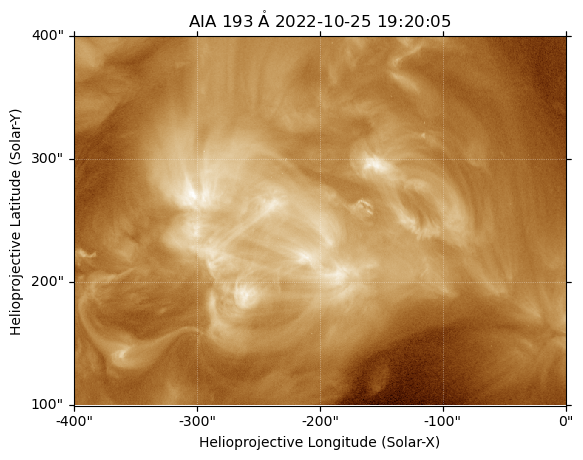

In [5]:
aia_193_map_1025 = sunpy.map.Map("../../src/AIA/20221025/193/lvl15/aia.lev1_euv_12s.2022-10-25T192003Z.193.image.fits")
aia_193_map_1025_crop = aia_193_map_1025.submap(SkyCoord(-400*u.arcsec, 100*u.arcsec,frame=aia_193_map_1025.coordinate_frame),
                                                top_right=SkyCoord(0*u.arcsec, 400*u.arcsec,frame=aia_193_map_1025.coordinate_frame))
aia_193_map_1025_crop.plot()

(-0.5, 666.5, -0.5, 500.5)

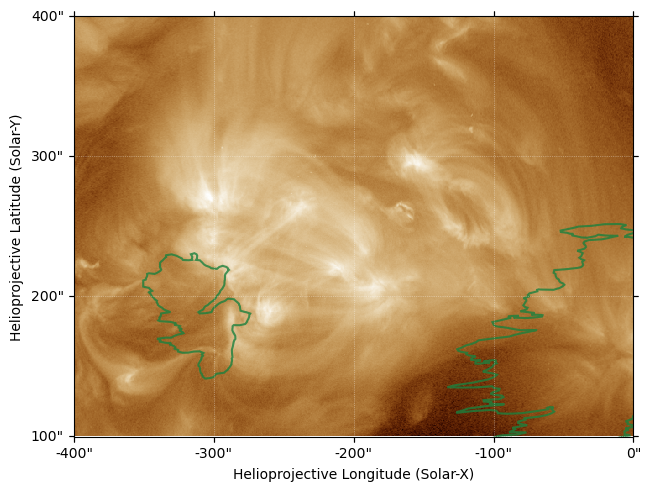

In [6]:
fig = plt.figure(constrained_layout=True)

ax = fig.add_subplot(111, projection=aia_193_map_1025_crop)
aia_193_map_1025_crop.plot(axes=ax, title=False)

bounds = ax.axis()
with propagate_with_solar_surface(rotation_model='rigid'):
    eis_east_region.to_pixel(aia_193_map_1025_crop.wcs).plot(ax=ax, edgecolor='#1B813E', lw=1.5,alpha=0.8)
    eis_west_region.to_pixel(aia_193_map_1025_crop.wcs).plot(ax=ax, edgecolor='#1B813E', lw=1.5,alpha=0.8)
ax.axis(bounds)

In [7]:
# based on mag2pfsspy https://github.com/STBadman/magnetograms2pfsspy/blob/master/mag2pfsspy.py#L12
# written by Samuel Badman, but updated to fit pfsspy 1.2.0
# pfsspy is archived at this moment, but I still use it when the succeeding sunkit-magex is under development
# def extract_br(m):
# 	br = m.data
# 	br = br - np.nanmean(br)
# 	# GONG maps have their LH edge at -180deg, so roll to get it at 0deg
# 	br = np.roll(br, int((m.meta['CRVAL1'] + 180)/np.abs(m.meta['cdelt1'])), axis=1)
# 	br = np.nan_to_num(br)
# 	return br*1e5 # Gauss to nT

def hmi2pfsspy(filepath,rss=2.5,nr=60,ret_magnetogram=False,resample=None, map_type='daily'): 
	if map_type == 'daily':
		hmi_fits_data = fits.getdata(filepath,)
		hmi_fits_header = fits.getheader(filepath,)
		hmi_fits_header['CUNIT2'] = 'Sine Latitude'
		# for card in ['HGLN_OBS','CRDER1','CRDER2','CSYSER1','CSYSER2'] :
		# 	hmi_fits_header[card] = 0

		hmi_fits_header['T_OBS'] = hmi_fits_header['T_OBS'][:-8]+"_TAI"

		hmi_fits_data = np.nan_to_num(hmi_fits_data, nan=0.0)
		# since the cdelt1 is flipped, one should also update the crval1 either through sunpy.L0 (like sam) or manually from FITS header
		# hmi_fits_header['CRVAL1'] = 120 + sun.L0(time=hmi_fits_header['T_OBS']).to_value(u.deg)
		hmi_fits_header['CRVAL1'] = (2262*360*u.deg - (hmi_fits_header["CRVAL1"] + hmi_fits_header["NAXIS1"]*hmi_fits_header["CDELT1"])*u.deg).to_value(u.deg)
		# print(hmi_fits_header['CRVAL1'])

		hmi_map = sunpy.map.sources.HMISynopticMap(hmi_fits_data,hmi_fits_header)
	elif map_type == 'cr':
		hmi_map = sunpy.map.Map(filepath)
		hmi_map = sunpy.map.Map(np.nan_to_num(hmi_map.data, nan=0.0), hmi_map.meta)
		
	if resample is not None: 
		hmi_map = hmi_map.resample(resample)
	
	# br_hmi = extract_br(hmi_map)
	if ret_magnetogram:
		return hmi_map
	pfss_input = pfsspy.Input(hmi_map, nr, rss,)

	pfss_output = pfsspy.pfss(pfss_input)
	return pfss_output

In [8]:
hmi_daily_synoptic_map = hmi2pfsspy("../../src/HMI/CR2263/hmi.Mrdailysynframe_720s.20221025_120000_TAI.data.fits", 
                            resample=[1440,720]*u.pix,ret_magnetogram=True, map_type='daily')

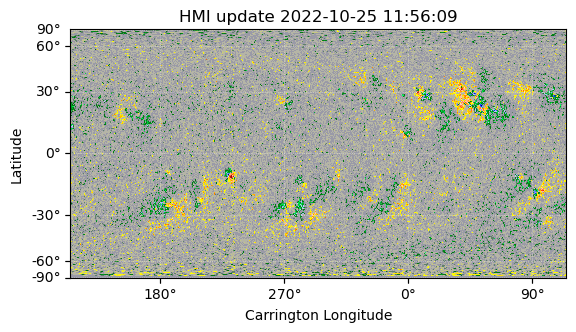

In [9]:
hmi_daily_synoptic_map.plot()

In [10]:
hmi_cr_synoptic_map = hmi2pfsspy("../../src/HMI/CR2263/hmi.synoptic_mr_polfil_720s.2263.Mr_polfil.fits",
                                resample=[1440,720]*u.pix,ret_magnetogram=True, map_type='cr')

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


For frame 'heliographic_stonyhurst' the following metadata is missing: dsun_obs,hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs,dsun_obs
 [sunpy.map.mapbase]


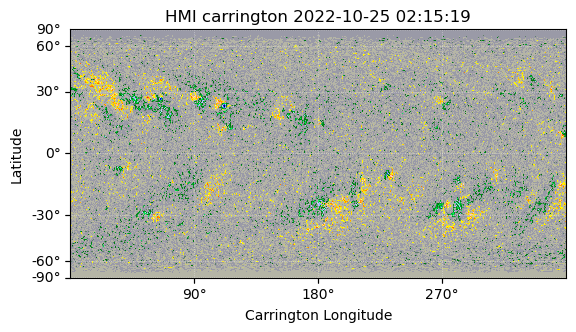

In [11]:
hmi_cr_synoptic_map.plot()

In [12]:
pfss_output = hmi2pfsspy("../../src/HMI/CR2263/hmi.Mrdailysynframe_720s.20221025_120000_TAI.data.fits",
                        resample=[720,360]*u.pix,nr=100, rss=2.5)

In [13]:
def trace_flines(pfss_output, seed, max_steps='auto'):
    tracer = tracing.FortranTracer(max_steps=max_steps)
    with propagate_with_solar_surface():
        flines = tracer.trace(seed, pfss_output)

    return flines

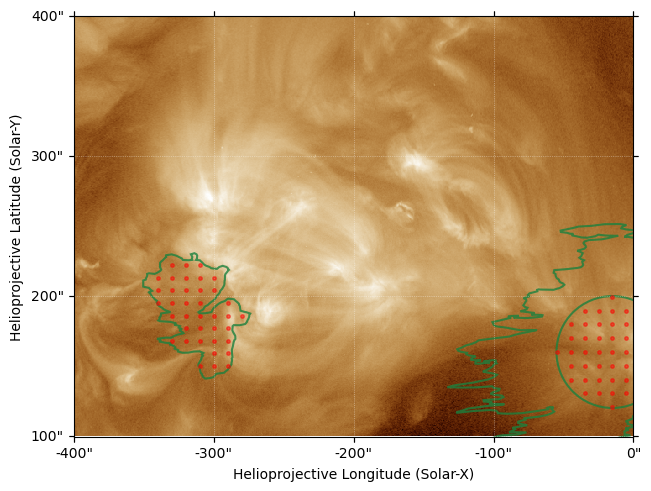

In [14]:
fig = plt.figure(constrained_layout=True)

ax = fig.add_subplot(111, projection=aia_193_map_1025_crop)
aia_193_map_1025_crop.plot(axes=ax, title=False)

bounds = ax.axis()
with propagate_with_solar_surface(rotation_model='rigid'):
    eis_east_region.to_pixel(aia_193_map_1025_crop.wcs).plot(ax=ax, edgecolor='#1B813E', lw=1.5,alpha=0.8)
    eis_west_region.to_pixel(aia_193_map_1025_crop.wcs).plot(ax=ax, edgecolor='#1B813E', lw=1.5,alpha=0.8)
ax.axis(bounds)

seed_east_lon, seed_east_lat = np.meshgrid(np.linspace(-350,-270,9), np.linspace(150,240,11))
seed_east = SkyCoord(seed_east_lon.ravel()*u.arcsec,seed_east_lat.ravel()*u.arcsec,frame=aia_193_map_1025_crop.coordinate_frame)
with propagate_with_solar_surface(rotation_model='rigid'):
    seed_east = seed_east[np.where(eis_east_region.contains(seed_east, aia_193_map_1025_crop.wcs))]
ax.plot_coord(seed_east,marker='.',color='red',markersize=5,alpha=0.5, lw=0)

seed_west_lon, seed_west_lat = np.meshgrid(np.linspace(-54.5,24.5,9), np.linspace(120.5,199.5,9))
seed_west = SkyCoord(seed_west_lon.ravel()*u.arcsec,seed_west_lat.ravel()*u.arcsec,frame=aia_193_map_1025_crop.coordinate_frame)
eis_west_region_circle = CircleSkyRegion(center=SkyCoord(-15*u.arcsec, 160*u.arcsec, frame=aia_193_map_1025_crop.coordinate_frame), radius=40*u.arcsec)
with propagate_with_solar_surface(rotation_model='rigid'):
    eis_west_region_circle.to_pixel(aia_193_map_1025_crop.wcs).plot(ax=ax, edgecolor='#1B813E', lw=1.5,alpha=0.8)
    seed_west = seed_west[np.where(eis_west_region_circle.contains(seed_west, aia_193_map_1025_crop.wcs))]
ax.plot_coord(seed_west,marker='.',color='red',markersize=5,alpha=0.5, lw=0)

In [15]:
# with propagate_with_solar_surface(rotation_model='rigid'):
east_flines = trace_flines(pfss_output, seed_east,)
west_flines = trace_flines(pfss_output, seed_west,)

/home/yjzhu/anaconda3/envs/sunpy/lib/python3.12/site-packages/pfsspy/output.py:95: UserWarning: Could not parse unit string "Mx/cm^2" as a valid FITS unit.
See https://fits.gsfc.nasa.gov/fits_standard.html for the FITS unit standards.
  warnings.warn(f'Could not parse unit string "{unit_str}" as a valid FITS unit.\n'
/home/yjzhu/anaconda3/envs/sunpy/lib/python3.12/site-packages/pfsspy/tracing.py:180: UserWarning: At least one field line ran out of steps during tracing.
You should probably increase max_steps (currently set to auto) and try again.
  warnings.warn(


In [16]:
def get_loop_length(line):
    c = line.coords.cartesian.xyz
    s = np.append(0., np.linalg.norm(np.diff(c.value, axis=1), axis=0).cumsum()) * c.unit
    return np.diff(s).sum()

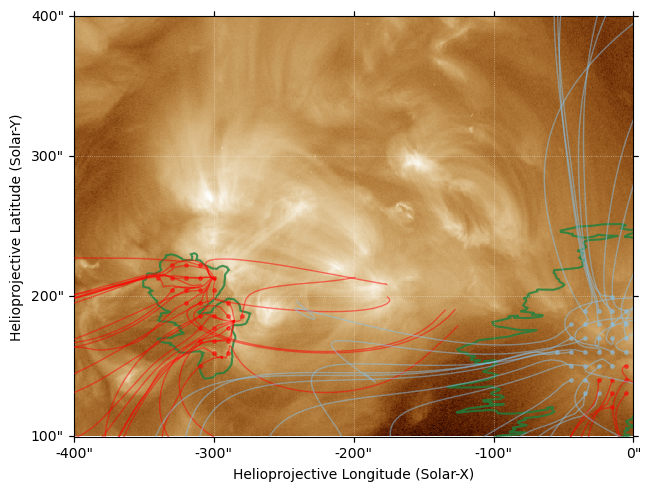

In [17]:
fig = plt.figure(constrained_layout=True)

ax = fig.add_subplot(111, projection=aia_193_map_1025_crop)
aia_193_map_1025_crop.plot(axes=ax, title=False)

bounds = ax.axis()
with propagate_with_solar_surface(rotation_model='rigid'):
    eis_east_region.to_pixel(aia_193_map_1025_crop.wcs).plot(ax=ax, edgecolor='#1B813E', lw=1.5,alpha=0.8)
    eis_west_region.to_pixel(aia_193_map_1025_crop.wcs).plot(ax=ax, edgecolor='#1B813E', lw=1.5,alpha=0.8)
ax.axis(bounds)

with propagate_with_solar_surface():
    for fline, seed in zip(east_flines, seed_east):
        if get_loop_length(fline) > 100 * u.Mm:
            if fline.is_open:
                ax.plot_coord(fline.coords, color='#89c3eb', linewidth=1,alpha=0.5)
                ax.plot_coord(seed, marker='.', color='#89c3eb', markersize=5,alpha=0.5, lw=0)
            else:
                ax.plot_coord(fline.coords, color='red', linewidth=1,alpha=0.5)
                ax.plot_coord(seed, marker='.', color='red', markersize=5,alpha=0.5, lw=0)
    
    for fline, seed in zip(west_flines, seed_west):
        if get_loop_length(fline) > 100 * u.Mm:
            if fline.is_open:
                ax.plot_coord(fline.coords, color='#89c3eb', linewidth=1,alpha=0.5)
                ax.plot_coord(seed, marker='.', color='#89c3eb', markersize=5,alpha=0.5, lw=0)
            else:
                ax.plot_coord(fline.coords, color='red', linewidth=1,alpha=0.5)
                ax.plot_coord(seed, marker='.', color='red', markersize=5,alpha=0.5, lw=0)
        

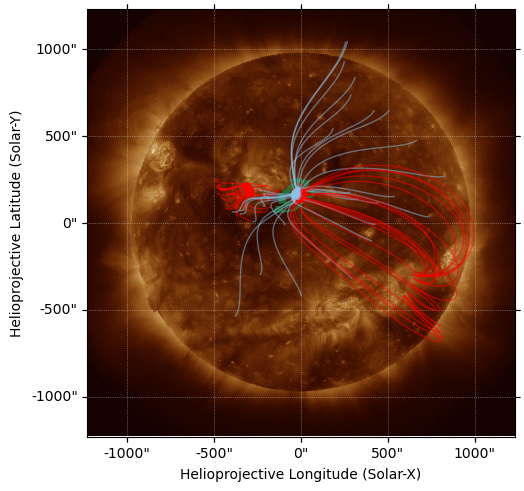

In [18]:
fig = plt.figure(constrained_layout=True)

ax = fig.add_subplot(111, projection=aia_193_map_1025)
aia_193_map_1025.plot(axes=ax, title=False)

bounds = ax.axis()
with propagate_with_solar_surface(rotation_model='rigid'):
    eis_east_region.to_pixel(aia_193_map_1025.wcs).plot(ax=ax, edgecolor='#1B813E', lw=1.5,alpha=0.8)
    eis_west_region.to_pixel(aia_193_map_1025.wcs).plot(ax=ax, edgecolor='#1B813E', lw=1.5,alpha=0.8)
ax.axis(bounds)

with propagate_with_solar_surface():
    for fline, seed in zip(east_flines, seed_east):
        if get_loop_length(fline) > 100 * u.Mm:
            if fline.is_open:
                ax.plot_coord(fline.coords, color='#89c3eb', linewidth=1,alpha=0.5)
                ax.plot_coord(seed, marker='.', color='#89c3eb', markersize=5,alpha=0.5, lw=0)
            else:
                ax.plot_coord(fline.coords, color='red', linewidth=1,alpha=0.5)
                ax.plot_coord(seed, marker='.', color='red', markersize=5,alpha=0.5, lw=0)
    
    for fline, seed in zip(west_flines, seed_west):
        if get_loop_length(fline) > 100 * u.Mm:
            if fline.is_open:
                ax.plot_coord(fline.coords, color='#89c3eb', linewidth=1,alpha=0.5)
                ax.plot_coord(seed, marker='.', color='#89c3eb', markersize=5,alpha=0.5, lw=0)
            else:
                ax.plot_coord(fline.coords, color='red', linewidth=1,alpha=0.5)
                ax.plot_coord(seed, marker='.', color='red', markersize=5,alpha=0.5, lw=0)
                


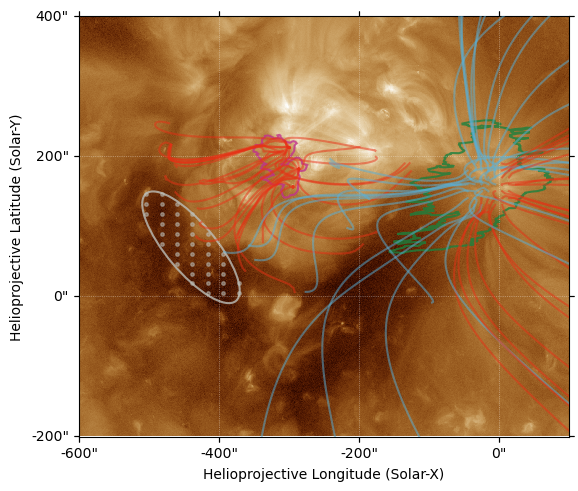

In [19]:
aia_193_map_1025_crop_large = aia_193_map_1025.submap(SkyCoord(-600*u.arcsec, -200*u.arcsec,frame=aia_193_map_1025.coordinate_frame),
                                                top_right=SkyCoord(100*u.arcsec, 400*u.arcsec,frame=aia_193_map_1025.coordinate_frame))

fig = plt.figure(constrained_layout=True)

ax = fig.add_subplot(111, projection=aia_193_map_1025_crop_large)
aia_193_map_1025_crop_large.plot(axes=ax, title=False)

bounds = ax.axis()
with propagate_with_solar_surface(rotation_model='rigid'):
    eis_east_region.to_pixel(aia_193_map_1025_crop_large.wcs).plot(ax=ax, edgecolor='#C1328E', lw=1.5,alpha=0.8)
    eis_west_region.to_pixel(aia_193_map_1025_crop_large.wcs).plot(ax=ax, edgecolor='#1B813E', lw=1.5,alpha=0.8)
ax.axis(bounds)

with propagate_with_solar_surface():
    for fline, seed in zip(east_flines, seed_east):
        if get_loop_length(fline) > 100 * u.Mm:
            if fline.is_open:
                ax.plot_coord(fline.coords, color='#58B2DC', linewidth=1.5,alpha=0.5)
                # ax.plot_coord(seed, marker='.', color='#89c3eb', markersize=5,alpha=0.5, lw=0)
            else:
                ax.plot_coord(fline.coords, color='#E83015', linewidth=1.5,alpha=0.5)
                # ax.plot_coord(seed, marker='.', color='red', markersize=5,alpha=0.5, lw=0)
    
    for fline, seed in zip(west_flines, seed_west):
        if get_loop_length(fline) > 100 * u.Mm:
            if fline.is_open:
                ax.plot_coord(fline.coords, color='#58B2DC', linewidth=1.5,alpha=0.5)
                # ax.plot_coord(seed, marker='.', color='#89c3eb', markersize=5,alpha=0.5, lw=0)
            else:
                ax.plot_coord(fline.coords, color='#E83015', linewidth=1.5,alpha=0.5)
                # ax.plot_coord(seed, marker='.', color='red', markersize=5,alpha=0.5, lw=0)

region_ch_boundary = EllipseSkyRegion(center=SkyCoord(-440*u.arcsec, 70*u.arcsec, frame=aia_193_map_1025_crop_large.coordinate_frame), 
                                      width=200*u.arcsec, height=70*u.arcsec, angle=-50*u.deg)
region_ch_boundary.to_pixel(aia_193_map_1025_crop_large.wcs).plot(ax=ax, edgecolor='#BDC0BA', lw=1.5,alpha=0.8)

seeds_ch_boundary_lon, seeds_ch_boundary_lat = np.meshgrid(np.linspace(-570,-350,11), np.linspace(-10,160,13))
seeds_ch_boundary = SkyCoord(seeds_ch_boundary_lon.ravel()*u.arcsec,seeds_ch_boundary_lat.ravel()*u.arcsec,frame=aia_193_map_1025_crop_large.coordinate_frame)
with propagate_with_solar_surface(rotation_model='rigid'):
    seeds_ch_boundary = seeds_ch_boundary[np.where(region_ch_boundary.contains(seeds_ch_boundary, aia_193_map_1025_crop_large.wcs))]
ax.plot_coord(seeds_ch_boundary,marker='.',color='#BDC0BA',markersize=5,alpha=0.5, lw=0)

In [20]:
flines_ch_boundary = trace_flines(pfss_output, seeds_ch_boundary,max_steps=5000)

/home/yjzhu/anaconda3/envs/sunpy/lib/python3.12/site-packages/pfsspy/tracing.py:180: UserWarning: At least one field line ran out of steps during tracing.
You should probably increase max_steps (currently set to 5000) and try again.
  warnings.warn(


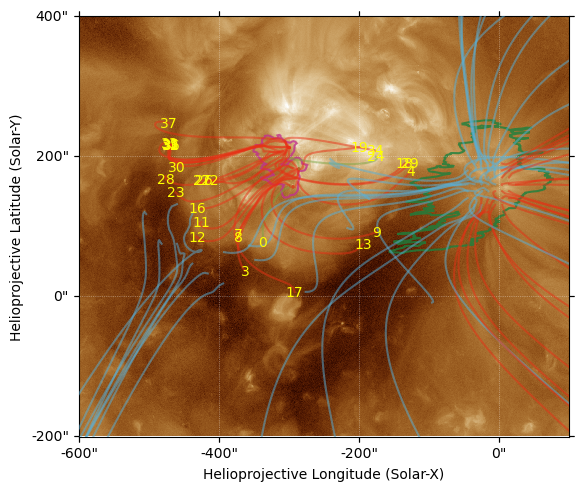

In [21]:
aia_193_map_1025_crop_large = aia_193_map_1025.submap(SkyCoord(-600*u.arcsec, -200*u.arcsec,frame=aia_193_map_1025.coordinate_frame),
                                                top_right=SkyCoord(100*u.arcsec, 400*u.arcsec,frame=aia_193_map_1025.coordinate_frame))

fig = plt.figure(constrained_layout=True)

ax = fig.add_subplot(111, projection=aia_193_map_1025_crop_large)
aia_193_map_1025_crop_large.plot(axes=ax, title=False)

bounds = ax.axis()
with propagate_with_solar_surface(rotation_model='rigid'):
    eis_east_region.to_pixel(aia_193_map_1025_crop_large.wcs).plot(ax=ax, edgecolor='#C1328E', lw=1.5,alpha=0.8)
    eis_west_region.to_pixel(aia_193_map_1025_crop_large.wcs).plot(ax=ax, edgecolor='#1B813E', lw=1.5,alpha=0.8)
ax.axis(bounds)

with propagate_with_solar_surface():
    for ii, (fline, seed) in enumerate(zip(east_flines, seed_east)):
        if get_loop_length(fline) > 100 * u.Mm:
            if fline.is_open:
                ax.plot_coord(fline.coords, color='#58B2DC', linewidth=1.5,alpha=0.5)
                # ax.plot_coord(seed, marker='.', color='#89c3eb', markersize=5,alpha=0.5, lw=0)
            else:
                try:
                    vel_at_another_footpoint = sunpy.map.sample_at_coords(eis_195_velmap_shift_1025, 
                                                                            SkyCoord([fline.coords[0],]))
                except:
                    vel_at_another_footpoint = np.nan
                fline_coords_pixels = aia_193_map_1025_crop_large.wcs.world_to_pixel(fline.coords)
                ax.text(fline_coords_pixels[0][0],fline_coords_pixels[1][0],str(ii),color='yellow',fontsize=10, transform=ax.transData,
                        va='center',ha='center')
                if vel_at_another_footpoint > 0:
                    ax.plot_coord(fline.coords, color='#7BA23F', linewidth=1.5,alpha=0.5)
                else:
                    ax.plot_coord(fline.coords, color='#E83015', linewidth=1.5,alpha=0.5)
                # ax.plot_coord(seed, marker='.', color='red', markersize=5,alpha=0.5, lw=0)
    
    for ii, (fline, seed) in enumerate(zip(west_flines, seed_west)):
        if get_loop_length(fline) > 100 * u.Mm:
            if fline.is_open:
                ax.plot_coord(fline.coords, color='#58B2DC', linewidth=1.5,alpha=0.5)
                # ax.plot_coord(seed, marker='.', color='#89c3eb', markersize=5,alpha=0.5, lw=0)
            else:
                ax.plot_coord(fline.coords, color='#E83015', linewidth=1.5,alpha=0.5)
                # ax.plot_coord(seed, marker='.', color='red', markersize=5,alpha=0.5, lw=0)

    for fline, seed in zip(flines_ch_boundary, seeds_ch_boundary):
        if get_loop_length(fline) > 100 * u.Mm:
            if fline.is_open:
                ax.plot_coord(fline.coords, color='#58B2DC', linewidth=1.5,alpha=0.5)
                # ax.plot_coord(seed, marker='.', color='#BDC0BA', markersize=5,alpha=0.5, lw=0)
            else:
                pass
                # ax.plot_coord(fline.coords, color='#E83015', linewidth=1.5,alpha=0.5)
                # ax.plot_coord(seed, marker='.', color='#BDC0BA', markersize=5,alpha=0.5, lw=0)

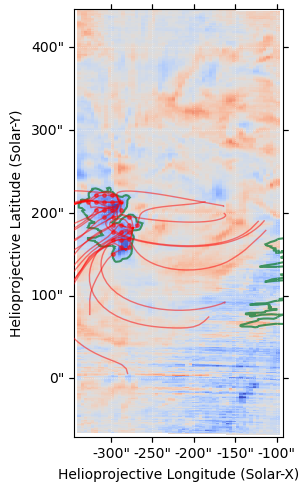

In [22]:
fig = plt.figure(constrained_layout=True)

ax = fig.add_subplot(111, projection=eis_195_velmap_shift_1025)
eis_195_velmap_shift_1025.plot(axes=ax, title=False,
                               norm=ImageNormalize(vmin=-20, vmax=20),
                               cmap='coolwarm', 
                               aspect=eis_195_velmap_shift_1025.scale.axis2/eis_195_velmap_shift_1025.scale.axis1)

bounds = ax.axis()
with propagate_with_solar_surface(rotation_model='rigid'):
    eis_east_region.to_pixel(eis_195_velmap_shift_1025.wcs).plot(ax=ax, edgecolor='#1B813E', lw=1.5,alpha=0.8)
    eis_west_region.to_pixel(eis_195_velmap_shift_1025.wcs).plot(ax=ax, edgecolor='#1B813E', lw=1.5,alpha=0.8)
ax.axis(bounds)

with propagate_with_solar_surface(rotation_model='rigid'):
    for ii, (fline, seed) in enumerate(zip(east_flines, seed_east)):
        if get_loop_length(fline) > 100 * u.Mm:
            if fline.is_open:
                ax.plot_coord(fline.coords, color='#89c3eb', linewidth=1,alpha=0.5)
                ax.plot_coord(seed, marker='.', color='#89c3eb', markersize=5,alpha=0.5, lw=0)
            else:
                ax.plot_coord(fline.coords, color='red', linewidth=1,alpha=0.5)
                fline_coords_pixels = eis_195_velmap_shift_1025.wcs.world_to_pixel(fline.coords)
                ax.plot_coord(seed, marker='.', color='red', markersize=5,alpha=0.5, lw=0)
                footpoint_pixel = eis_195_velmap_shift_1025.wcs.world_to_pixel(fline.source_surface_footpoint)
                # ax.plot_coord(fline.coords[:10], marker='.', color='red', markersize=5,alpha=0.5, lw=0)
                # print(fline.source_surface_footpoint)
                # print(fline.coords[0])
                # print(fline.coords[-1])
                # ax.text(fline_coords_pixels[0][0],fline_coords_pixels[1][0],str(ii),color='yellow',fontsize=10, transform=ax.transData)
                # print(footpoint_pixel)
    
    # for fline, seed in zip(west_flines, seed_west):
    #     if get_loop_length(fline) > 100 * u.Mm:
    #         if fline.is_open:
    #             ax.plot_coord(fline.coords, color='#89c3eb', linewidth=1,alpha=0.5)
    #             ax.plot_coord(seed, marker='.', color='#89c3eb', markersize=5,alpha=0.5, lw=0)
    #         else:
    #             ax.plot_coord(fline.coords, color='red', linewidth=1,alpha=0.5)
    #             ax.plot_coord(seed, marker='.', color='red', markersize=5,alpha=0.5, lw=0)


In [23]:
def read_qmap(filepath,layer=0):
    with fits.open(filepath) as hdul:
        data = hdul[1].data[layer,:,:-1]
        header = hdul[1].header
        header['T_OBS'] = header['T_OBS'][:-8]+"_TAI"
        header["NAXIS1"] = header["NAXIS1"] - 1

        old_crpix1 = header["CRPIX1"]

        # for some unknown reason, sunpy cannot accept a heliogaographic WCS with CRPIX1 not at the center of the map
        # so I have to manually shift the CRPIX1 and CRVAL1 to the center of the map

        header["CRPIX1"] = (1 + header["NAXIS1"])/2
        header["CRVAL1"] = header["CRVAL1"] + (old_crpix1 - header["CRPIX1"])*header["CDELT1"]

    
    
        hmi_qmap_header_new = sunpy.map.make_fitswcs_header(data=data,
                                                        coordinate=SkyCoord(2262*360*u.deg - (header["CRVAL1"] + (header["NAXIS1"])*header["CDELT1"])*u.deg,
                                                                header["CRVAL2"]*u.deg,
                                                                rsun=696000000.*u.m,
                                                                frame="heliographic_carrington",
                                                                obstime=header["T_OBS"]),
                                                        reference_pixel=u.Quantity([header["CRPIX1"] - 1,header["CRPIX2"] - 1]*u.pix),
                                                        scale=u.Quantity([-header["CDELT1"],header["CDELT2"]]*u.deg/u.pix),
                                                        projection_code="CAR",
                                                        )
        map_size = data.shape[::-1]
        # cut the -90 and 90 degree pixel to fit into sunpy map (avoiding the overflow of the pixel boundary at the poles)
        return sunpy.map.Map(data, hmi_qmap_header_new).submap([0, 1]*u.pix, top_right=[map_size[0], map_size[1]-2]*u.pix)

hmi_qmap_1025 = read_qmap("../../src/HMI/20221025/qmap/hmi.q_synframe.20221025_120000_TAI.slogQ.fits")

For frame 'heliographic_stonyhurst' the following metadata is missing: dsun_obs,hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs,dsun_obs
 [sunpy.map.mapbase]


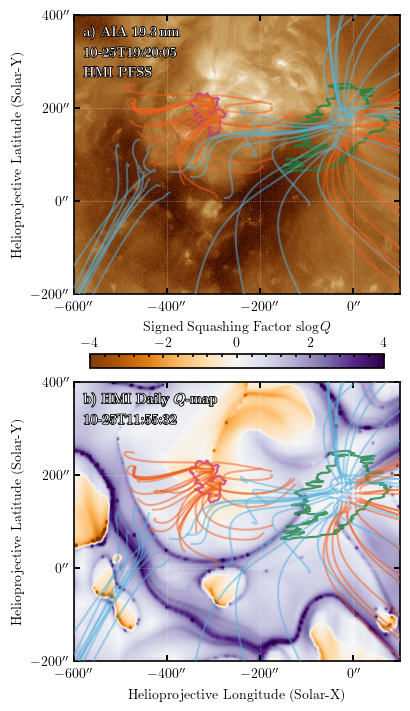

In [24]:
aia_193_map_1025_crop_large = aia_193_map_1025.submap(SkyCoord(-600*u.arcsec, -200*u.arcsec,frame=aia_193_map_1025.coordinate_frame),
                                                top_right=SkyCoord(100*u.arcsec, 400*u.arcsec,frame=aia_193_map_1025.coordinate_frame))
with propagate_with_solar_surface(rotation_model='rigid'):
    hmi_qmap_1025_repro_aia_crop_large = hmi_qmap_1025.reproject_to(aia_193_map_1025_crop_large.wcs, algorithm='adaptive')

with rc_context(ms_style_dict):
    fig = plt.figure(figsize=(4,7),constrained_layout=True)

    ax1 = fig.add_subplot(211, projection=aia_193_map_1025_crop_large)
    im1 = aia_193_map_1025_crop_large.plot(axes=ax1, title=False, cmap='sdoaia193',)

    ax2 = fig.add_subplot(212, projection=aia_193_map_1025_crop_large)
    im2 = hmi_qmap_1025_repro_aia_crop_large.plot(axes=ax2, title=False, cmap='PuOr',
                                            norm=ImageNormalize(vmin=-4,vmax=4))

    for ax_ in (ax1, ax2):
        bounds = ax_.axis()
        with propagate_with_solar_surface(rotation_model='rigid'):
            eis_east_region.to_pixel(aia_193_map_1025_crop_large.wcs).plot(ax=ax_, edgecolor='#C1328E', lw=1.5,alpha=0.8)
            eis_west_region.to_pixel(aia_193_map_1025_crop_large.wcs).plot(ax=ax_, edgecolor='#1B813E', lw=1.5,alpha=0.8)
        ax_.axis(bounds)

    with propagate_with_solar_surface():
        for fline, seed in zip(east_flines, seed_east):
            if get_loop_length(fline) > 100 * u.Mm:
                if fline.is_open:
                    ax1.plot_coord(fline.coords, color='#58B2DC', linewidth=1.5,alpha=0.5)
                    ax2.plot_coord(fline.coords, color='#58B2DC', linewidth=1.5,alpha=0.5)
                else:
                    ax1.plot_coord(fline.coords, color='#F05E1C', linewidth=1.5,alpha=0.5)
                    ax2.plot_coord(fline.coords, color='#F05E1C', linewidth=1.5,alpha=0.5)
        
        for fline, seed in zip(west_flines, seed_west):
            if get_loop_length(fline) > 100 * u.Mm:
                if fline.is_open:
                    ax1.plot_coord(fline.coords, color='#58B2DC', linewidth=1.5,alpha=0.5)
                    ax2.plot_coord(fline.coords, color='#58B2DC', linewidth=1.5,alpha=0.5)
                else:
                    ax1.plot_coord(fline.coords, color='#F05E1C', linewidth=1.5,alpha=0.5)
                    ax2.plot_coord(fline.coords, color='#F05E1C', linewidth=1.5,alpha=0.5)

        for fline, seed in zip(flines_ch_boundary, seeds_ch_boundary):
            if get_loop_length(fline) > 100 * u.Mm:
                if fline.is_open:
                    ax1.plot_coord(fline.coords, color='#58B2DC', linewidth=1.5,alpha=0.5)
                    ax2.plot_coord(fline.coords, color='#58B2DC', linewidth=1.5,alpha=0.5)
                else:
                    pass

    ax1.coords[0].axislabels.set_visible(False)
    clb, clb_ax = plot_colorbar(im2, ax2,
                                bbox_to_anchor=(0.05,1.05,0.9,0.05), orientation='horizontal',
                                fontsize=10,scilimits=(0,2),title=r'Signed Squashing Factor $\mathrm{slog} Q$')
    
    clb_ax.tick_params(top=True, bottom=False, labeltop=True, labelbottom=False,
                        length=3)
    clb_ax.xaxis.tick_top()
    clb_ax.xaxis.set_label_position('top') 
    offset_text = clb_ax.xaxis.get_offset_text()
    if offset_text is not None:
        offset_text.set_visible(False)

    ax1.text(0.03, 0.96, r"\textbf{a) AIA 19.3\,nm }" + "\n" + \
            r'\textbf{{{}}}\,'.format(aia_193_map_1025_crop_large.date.isot[5:-4]) + \
            "\n" + r"\textbf{HMI PFSS}", transform=ax1.transAxes, ha='left', va='top', fontsize=10,
            color='white', path_effects=[path_effects.Stroke(linewidth=1.2, foreground='black'), path_effects.Normal()],
            linespacing=1.8)
    
    ax2.text(0.03, 0.96, r"\textbf{b) HMI Daily} $\boldsymbol{Q}$\textbf{-map }" + "\n" + \
            r'\textbf{{{}}}\,'.format(hmi_qmap_1025.date.isot[5:-4]),
            transform=ax2.transAxes, ha='left', va='top', fontsize=10,
            color='white', path_effects=[path_effects.Stroke(linewidth=1.2, foreground='black'), path_effects.Normal()],
            linespacing=1.8)
    
    fig.savefig("../../figs/ms_eis_eui_upflow/upflow_pfss.pdf",dpi=300,bbox_inches='tight')
    plt.show()